# Applying Complex Orthogonal Decomposition to Lampreys swimming in fluid environment of various viscosity
# COD analysis on simulated data sets
## In this notebook, we perform initial COD analysis to take a look at traveling indices and complex orthogonal values
### Author: Yuexia Luna Lin (luna.lin@epfl.ch)
### Data provided by Prof. Eric Tytell.

# Start by loading some necessary libraries and our pre-processed dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from matplotlib import rc
import zipfile

import os
from os import listdir
from os.path import isfile, isdir, join
from scipy.interpolate import interp1d
from scipy.signal import hilbert
from scipy.fft import rfft, irfft
from scipy.linalg import eigh
from scipy.optimize import curve_fit, brute, minimize

# The following two lines is to be able toeasily convert
# comma decimal place to point decimal place
import locale
#locale.setlocale(locale.LC_NUMERIC, "fr_CH.ISO8859-15")
import time

# To read Eric's h5 file, we can't use Pandas since it requires a particular structure within the HDF5 file.
# So we need this library
import h5py

#%matplotlib inline
%matplotlib notebook

# Read in the simulated dataset

In [2]:
# We read in the pre-processed dataset
data_frame = pd.read_csv("../Data/sim_viscosity1x.csv")

# Only use when swimmer has reach steady velocity
data_frame = data_frame[data_frame["issteady"]!=0]

In [3]:
column_names = data_frame.columns.tolist() +  ['frame', 'comx', 'comy', 'bodyaxisx', 'bodyaxisy', 'bodycoordx', 'bodycoordy']
data_frame = data_frame.reindex(columns = column_names)
data_frame.head()

,t,s,xm,ym,viscosity,filename,issteady,frame,comx,comy,bodyaxisx,bodyaxisy,bodycoordx,bodycoordy
37557,3.0208,0.000000,-5.697774,6.729320,1x,simulations/sim54959-2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37558,3.0208,0.039266,-5.658510,6.728761,1x,simulations/sim54959-2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37559,3.0208,0.078518,-5.619249,6.728179,1x,simulations/sim54959-2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37560,3.0208,0.117798,-5.579989,6.727595,1x,simulations/sim54959-2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37561,3.0208,0.157061,-5.540731,6.727016,1x,simulations/sim54959-2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# A simple PCA function
def PCA(df):
    """ This function takes in a Pandas DataFrame that contains the (x,y)
    data, labeled as 'mxmm', 'mymm' respectively.
    It then calculates the two principal components of this set of data points."""
    
    x= df['xm'].tolist()
    y= df['ym'].tolist()
    comx = np.mean(x)
    comy = np.mean(y)
    standard_x = (x - comx)
    standard_y = (y - comy)
    
    # perform PCA
    D = np.vstack([standard_x, standard_y]).T
    Corr = D.T @ D
    U, S, Vh = np.linalg.svd(Corr)
    pca = U[:, np.argmax(S)]
    # If the principal vector is pointing to the tail, we flip it around
    if (np.dot(pca, D[0,:])) < 0:
        pca = -pca
    return comx, comy, pca

In [5]:
time_pts = data_frame['t'].unique()
frames = np.arange(len(time_pts),dtype=int)
for t,f in zip(time_pts, frames):
    # set frame number
    data_frame.loc[(data_frame['t'] == t), 'frame'] = f
    
data_frame['frame'] = data_frame['frame'].astype(int)

for f in frames:
    comx, comy, pca = PCA(data_frame.loc[data_frame['frame']==f])
    # set the values of comx, comy, bodyaxisx, bodyaxisy of this frame
    data_frame.loc[(data_frame['frame'] == f), 'comx'] = comx
    data_frame.loc[(data_frame['frame'] == f), 'comy'] = comy
    data_frame.loc[(data_frame['frame'] == f), 'bodyaxisx'] = pca[0]
    data_frame.loc[(data_frame['frame'] == f), 'bodyaxisy'] = pca[1]

# We can apply the following calcuation to the entire dataframe:
# calcuation the projection of (x, y) in the lab frame onto the body frame
data_frame.loc[:, 'bodycoordx'] = (data_frame['xm'] - data_frame['comx']) * data_frame['bodyaxisx'] \
                                   + (data_frame['ym'] - data_frame['comy']) * data_frame['bodyaxisy']
data_frame.loc[:, 'bodycoordy'] = - (data_frame['xm'] - data_frame['comx'])  * data_frame['bodyaxisy'] \
                                   + (data_frame['ym'] - data_frame['comy'])  * data_frame['bodyaxisx']   

# We define two functions to extract body position data 
- (x, y) in the lab frame
- (x, y) in the body frame (body aligned with $x$-axis)

## We can then visualize the raw data: in the lab frame or in body frame.

In [6]:
def extract_single_trial_bodyframe(df):
    """ This function extracts the y coordinates at each tracking point on the fish,
    in the frame where COM is at the origin, and the body axis align with x axis.""" 

    
    xdata = np.asarray(data_frame[data_frame['frame']==0]['s'])
    num_parts=len(xdata)
    frames = df['frame'].unique()
    num_frames = len(frames)
    ydata = np.empty([num_frames, num_parts])
    
    for fr in frames:
        start = fr*num_parts
        finish = (fr+1)*num_parts
        ydata[fr] = df.iloc[start:finish].loc[:,'bodycoordy'].values
        
    return xdata, ydata

def extract_single_trial(df):
    """ This function extracts the y coordinates at each tracking point on the fish,
    in the lab frame.""" 

    frames = df['frame'].unique()
    num_frames = len(frames)
    
    # Average the bodypart coordinate (along body axis) over time
    # First get unique body parts names
    xdata = np.asarray(data_frame[data_frame['frame']==0]['s'])
    num_parts=len(xdata)

    ydata = np.empty([num_frames, num_parts])
    xdata = np.empty_like(ydata)
    
    for fr in frames:
        start = fr*num_parts
        finish = (fr+1)*num_parts
        ydata[fr] = df.iloc[start:finish].loc[:,'ym'].values
        xdata[fr] =  df.iloc[start:finish].loc[:,'xm'].values
    return xdata, ydata

## Note that "%matplotlib notebook" is needed for animation to show up in the notebook.
## If "%matplotlib inline" has been used before, this may not work anymore in this session. Restart the session, and only issue "%matplotlib notebook" command.

<IPython.core.display.Javascript object>


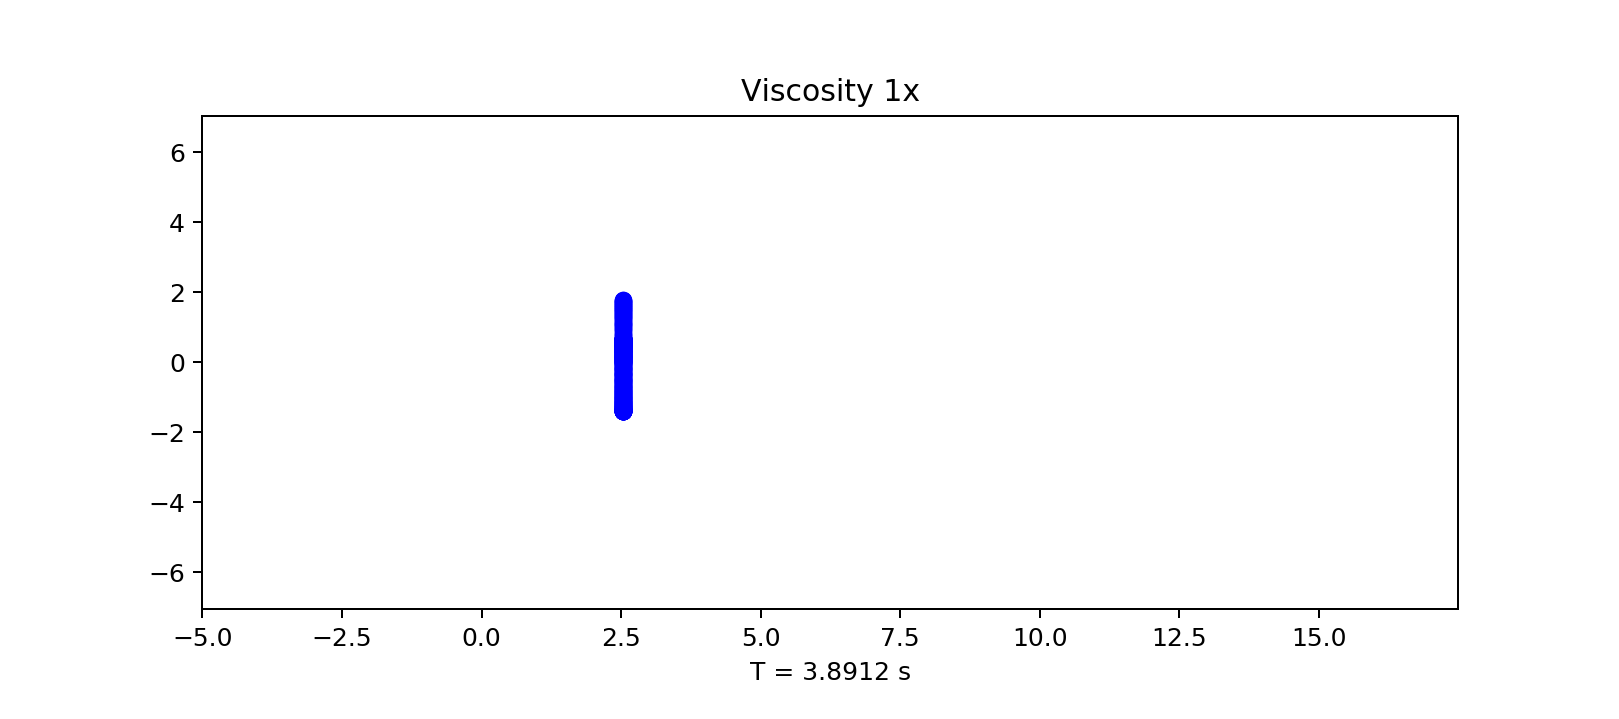

In [7]:
# We test this out on a few trials and see how the fish swim, the heading direction is also drawn on the animation
# Can change values of IND and TRIAL to look at different ones

xdata, ydata = extract_single_trial(data_frame)

# Animate the swimming fish as a line-point plot
fig, ax = plt.subplots(figsize=(9,4))

ln, = plt.plot([], [], 'bo-')
hd, = plt.plot([], [], 'ro')
def init():
    ymax = np.max(ydata)+5
    ymin = np.min(ydata)-5
    xmin = np.min(xdata)-5
    xmax = np.max(xdata)+5
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect((ymax-ymin)/(xmax-xmin))
    ax.set_title("Viscosity 1x")
    return ln,


def update(frame):
    ln.set_data(xdata[frame], ydata[frame])
    #hd.set_data(xdata_interp, ydata_interp[frame])
    hd.set_data(xdata[frame, 0], ydata[frame,0])
    
    ax.set_xlabel('T = %.4f s'%(time_pts[frame]))
    return ln,

ani = FuncAnimation(fig, update, frames=ydata.shape[0], init_func=init, blit=True);

# # Uncomment this if want to save the animation to file
# # !! I used 'ffmpeg' as my video writer, but on another computer system, it could be different
# ani.save('./labframe_ind{}_trial{}_vis{}.mp4'.format(IND, TRIAL, visc), writer='ffmpeg', fps=50)

# Define the complex orthogonal decomposition functions, and use them to calculate the COD of a given trial, and its traveling indices

In [8]:
# We pass in the real signals
# Organized as: each row represent the whole fish (N body parts) at a time point
def complex_orthog_decomp(real_signal, tf_type=None, dc_type=None):
    """ This function performs COD on real signal, by first complexifying it,
    then decomposing the complex correlation matrix."""
    
    nf = real_signal.shape[0]
    zdata = np.empty_like(real_signal)
    
    if tf_type == None or tf_type == 'FFT':
        # Transform the time series at each sensor location into complex signal
        # See https://en.wikipedia.org/wiki/Analytic_signal
        
        ffty = np.fft.fft(real_signal, axis=0)
        freq = np.fft.fftfreq(nf)
        ffty[freq>0, :] = 2*ffty[freq>0, :]
        ffty[freq<0, :] = 0
        zdata = np.fft.ifft(ffty, axis=0)
        #print(zdata.shape)

    elif tf_type == 'H':

    # According to scipy documentation, hilbert transform output x_a(t) = x(t) + iy(t),
    # which is the complex signal COD calls for (Feeny, 2008)
    # We transform along column direction, axis=0, since each row represents a time point
        zdata = hilbert (real_signal, axis=0)
    
    else: 
        print("Transformation type can either be Fourier Transform (FFT) or Hilbert Transform (H).")
        print("Default is FFT.")
        
    # Cast the ndarray zdata to matrix for convenience
    # The complex ensemble matrix is organized as follows:
    # each row is a time series of signal at a given sensor.
    # In the fish example, in each row we have the time series of a body part
    Z = np.asmatrix(zdata).T

    # Assemble the complex correlation matrix
    R = 1./nf * (Z @ (Z.H))

    #print("Check complex correlation matrix is Hermitian norm(R-R.H): ", np.linalg.norm(R-R.H))
    
    num_samples = real_signal.shape[1]
    U = np.zeros([num_samples, num_samples])
    S = np.zeros(num_samples)
    Vh = np.empty_like(U)
    if dc_type == 'eig':
        # Compute the eigenvalues and eigenvectors of the correlation matrix
        # Using eigen decomposition
        S, U = np.linalg.eigh(R)
        S = np.flip(S)
        U = np.flip(U, axis=1)
        
    elif dc_type == None or dc_type == 'svd':
        # Since R is Hermitian (complex conjugate symmetric)
        # its SVD is just eigen decoposition
        U, S, Vh = np.linalg.svd(R)
        
    else: 
        print("Decomposition type can either be eigen 'eig' or SVD 'svd'.")
        print("Default is SVD.")

        
    return zdata, Z, R, S, U

# Use the real and imaginary part of the eigenmodes to compute traveling index
def traveling_index(U):
    """ This function computes the traveling index for every complex orthogonal mode."""
    
    # The number of traveling indices is the number of modes (columns in eigenvector matrix)
    tr_ind = np.zeros(U.shape[1])

    # For each mode, we create a rectangular matrix with columns being the real and imag part of the mode
    # The traveling index is the inverse of the condition number of this matrix
    for i in range(len(tr_ind)):
        tmp = np.concatenate( (np.real (U[:, i]).reshape(-1,1) , np.imag(U[:, i]).reshape(-1,1)), axis=1)
        cond = np.linalg.cond(tmp)
        tr_ind[i] = 1./cond
        
    return tr_ind

# Compute traveling index, winding number of first mode in complex plane, and wavelength

In [9]:
xdata, ydata = extract_single_trial_bodyframe(data_frame)
zdata, Z, R, S, U = complex_orthog_decomp(ydata, tf_type = 'H', dc_type = 'svd')

ti = traveling_index(U)

In [28]:
L = data_frame['s'].unique().max()
mode=0
first_mode = U[:, mode]
shifted_real = np.array(np.real(first_mode) - np.mean(np.real(first_mode))).flatten()
shifted_imag = np.array(np.imag(first_mode) - np.mean(np.imag(first_mode))).flatten()
#         print( np.mean(np.real(first_mode)), np.sum(np.real(first_mode)) )

tot_angle = 0
exceed_2pi = False
wavelength_frac = -1

# this is how we compute winding number
# Integrate the angles, and divide by 2PI
for l in range(1,len(first_mode)):
    #l = len(first_mode) - l
    last_vector = np.array([shifted_real[l-1], shifted_imag[l-1]])
    this_vector = np.array([shifted_real[l], shifted_imag[l]])
    #print(last_vector, this_vector)
    last_tot = tot_angle
    tot_angle += np.arccos( np.dot(last_vector, this_vector)\
                           / np.linalg.norm(last_vector)/np.linalg.norm(this_vector) )
    # We keep track at which point winding number becomes 1, by linearly interpolating
    # between the points before and after winding number = 1
    if not exceed_2pi and tot_angle>= np.pi * 2:
        wavelength_frac = l-1 + (np.pi * 2 - last_tot)/ (tot_angle - last_tot)
        exceed_2pi = True

winding_number = tot_angle / 2/np.pi
wave_length = L *wavelength_frac / (xdata.shape[0]-1)

In [29]:
print("Wavelength by fraction calculation: ", wave_length)
print("Wavelength by simply dividing L by winding number: ", L/winding_number)

Wavelength by fraction calculation:  9.902420921597585
Wavelength by simply dividing L by winding number:  9.47314530675308


<IPython.core.display.Javascript object>


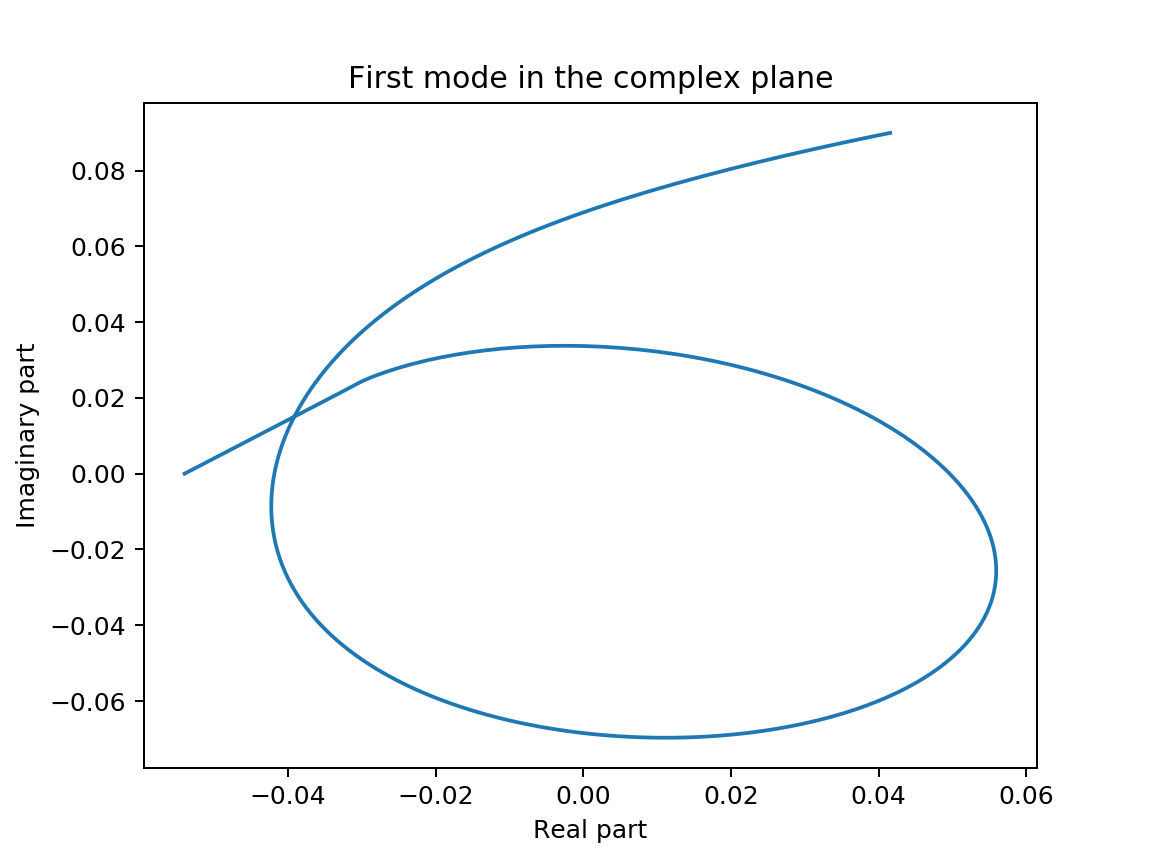

In [31]:
plt.figure()
plt.plot(np.real(U[:,0]), np.imag(U[:,0]))
plt.title("First mode in the complex plane")
plt.ylabel("Imaginary part")
plt.xlabel("Real part")
plt.show()